In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')
import scipy.io as sio
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from pyearth import Earth, export
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "/Users/xizheng/Documents/florin/respiration/K1/K1_20191226_r0_traces.mat"
Traces = sio.loadmat(filepath)['Traces']

In [3]:
move_sniff_trial_valid_full = []
s = ""

for idx in range(10):
    
    # resp
    resp = Traces[0,0]['Sniffs'][0,idx].flatten()
    if len(resp) == 0:
        print("skipping trial", idx)
        continue
    windowsize = 15
    resp = resp - np.median(resp)
    resp = -resp
    resp = np.convolve(resp, np.ones(windowsize), 'same') / windowsize
    resp_pks_2, _ = find_peaks(-resp, prominence=0.3, height=0.2, distance=10)
    
    trial_on = Traces[0,0]['Trial'][0,idx].flatten()
    
    # lever
    lever = Traces[0,0]['Lever'][0,idx].flatten()
    lever = savgol_filter(lever, 25, 4)
    x = np.arange(len(lever))

    #Fit an Earth model
    model = Earth(thresh=1e-5, minspan=30, penalty=10.0, check_every=1)
    model.fit(x,lever)
    
    s += export.export_python_string(model, function_name=f"model_{idx}")
    s += "\n"
    
    y_hat = model.predict(x)

    knots = []
    for bf in model.basis_.piter():
        if bf.has_knot():
            knots.append(bf.get_knot())
    vel = np.gradient(y_hat)
    acc = np.gradient(vel)
    peaks, _ = find_peaks(np.abs(acc), height=0.003, distance=20)
    
    # moves
    movement = np.zeros(len(peaks)-1)
    for i in range(len(peaks)-1):
        movement[i] = abs(lever[peaks[i+1]] - lever[peaks[i]])

    movement_signal = np.zeros(len(lever))
    movement_signal[peaks[:-1]] = movement
    large_thresh = 0
    movement_signal_large = movement_signal > large_thresh
    
    # combine together
    sniff_intervals = np.diff(resp_pks_2)
    move_sniff_trial = np.empty((len(resp_pks_2)-1, 600))
    move_sniff_trial[:] = np.nan
    for start_idx in range(len(resp_pks_2)-1):
        if trial_on[resp_pks_2[start_idx]] != 0 and resp_pks_2[start_idx] <= 1000: 
            move_sniff_trial[start_idx,:sniff_intervals[start_idx]+50] = movement_signal_large[resp_pks_2[start_idx]-50:resp_pks_2[start_idx+1]]
            
    sniff_trial_lengths = np.sum(~np.isnan(move_sniff_trial), 1)
    a_order_trial = np.argsort(sniff_trial_lengths)[::-1]
    move_sniff_trial_sorted = move_sniff_trial[a_order_trial,:]

    # move_sniff_trial_sorted = move_sniff_trial
    move_sniff_trial_sorted_valid = move_sniff_trial_sorted[~np.isnan(move_sniff_trial_sorted).all(axis=1),:]
    sniff_trial_lengths_valid = sniff_trial_lengths[sniff_trial_lengths != 0] - 50
    
    print(f"trial {idx} has {move_sniff_trial_sorted_valid.shape[0]} sniffs")
    
    move_sniff_trial_valid_full.append(move_sniff_trial_sorted_valid)


skipping trial 0
trial 1 has 7 sniffs
trial 2 has 6 sniffs
trial 3 has 5 sniffs
trial 4 has 7 sniffs
trial 5 has 4 sniffs
trial 6 has 5 sniffs
trial 7 has 5 sniffs
trial 8 has 4 sniffs
trial 9 has 3 sniffs


In [4]:
# sort
move_sniff_trial_valid_full = np.vstack(move_sniff_trial_valid_full)
sniff_trial_full_lengths = np.sum(~np.isnan(move_sniff_trial_valid_full), 1)
a_order_trial_full = np.argsort(sniff_trial_full_lengths)[::-1]
move_sniff_trial_valid_full_sorted = move_sniff_trial_valid_full[a_order_trial_full,:]

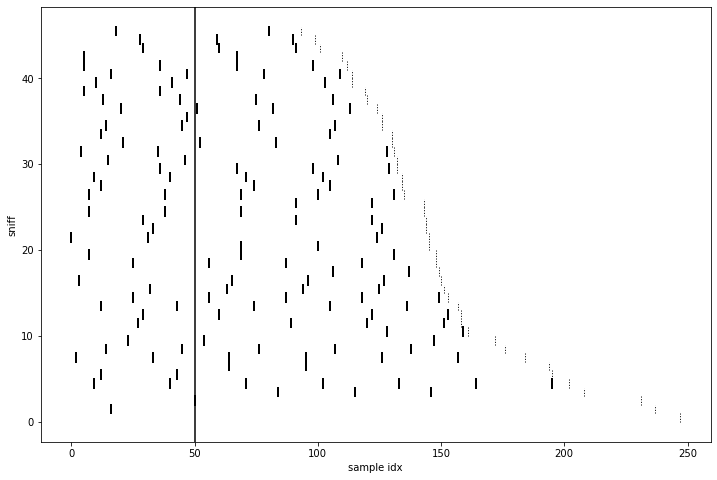

In [10]:
plt.figure(figsize=(12,8))
for i in range(move_sniff_trial_valid_full_sorted.shape[0]):
    moves = np.where(move_sniff_trial_valid_full_sorted[i,:] == 1)[0]
    for j in range(len(moves)):
        plt.plot((moves[j], moves[j]), (i, i+1), 'k', linewidth=2)
    trial_off = np.sum(~np.isnan(move_sniff_trial_valid_full_sorted[i,:]))
    plt.plot((trial_off, trial_off), (i, i+1), ':k', linewidth=1)
plt.axvline(50, color='k')
plt.xlabel('sample idx')
plt.ylabel('sniff')
plt.show()


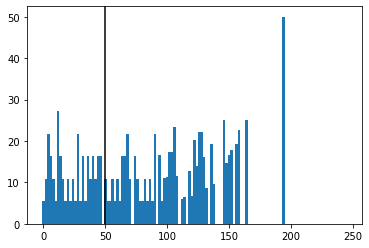

In [9]:
mean_moves = np.nanmean(move_sniff_trial_valid_full_sorted, axis=0)
binsize = 2
bins = np.arange(0,600,binsize)
bin_sums, bin_edges, binnumber = binned_statistic(np.arange(0,600), mean_moves, 'sum', bins=bins)

plt.bar(bin_edges[:-1], bin_sums/(0.002*binsize), binsize)
plt.axvline(50, color='k')
plt.xlabel('sample idx')
plt.ylabel('move rate')
plt.show()

In [7]:
f = open("models.txt", "w")
f.write(s)
f.close()